#### Load the libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
# from gensim.models.wrappers import LdaMallet


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

### Connect to drive to get the data

In [3]:
import pandas as pd
df_news = pd.read_pickle("udemy_reviews.pkl")
# Aplica pos/neg
df_news['tag']=df_news['rating'].apply(lambda x: 'pos' if x >= 4 else 'neg')
# Filtra los que solamente dicen una palabra (ej. "Excelente!")
df_news = df_news[df_news['comment'].str.contains("\s")]
# Filtra los que dicen menos de 12 letras (ej. "Excelente!")
df_news = df_news[df_news['comment'].str.len() >= 12]
df_news = df_news[df_news['tag']=='neg']#.sample(2000)
df_news[df_news['tag']=='neg'].sample(10)


# Recomendación:
# usar los comentarios con >=5 palabras


,id,course,rating,comment,user,tag
69741,27090344,1208340,3.0,"hasta ahora viene siendo bastante claro, se aprende al escucharlos clarmamente",Javiera Soto,neg
6676,46204884,1146754,1.0,"Según se indicaba en la descripción, debería valer para cualquier versión de Maya, pero al empezar el curso se indica que se usa MentalRay y en Maya 2019 ya no está disponible, por lo que a mi ya no me sirve este curso",Juan Sanchez,neg
61854,49021826,1954876,3.0,Mayor profundizacion,jhovan Kesternich,neg
59240,26198046,1429660,3.0,Es un Curso para nociones del tema. Pero falta mas profundidad en la materia.,Oscar Crespo,neg
3606,75968880,860984,2.0,El curso en el titulo dice Blender 2.9X y en realidad es de Blender 2.7X,Kevin César Orrala Nevares,neg
50835,26015448,1345468,1.0,"Es un buen curso para quien realmente no sabe nada, absolutamente nada de Adobe",Alma Manzano,neg
71404,62553220,2310326,2.5,El tutor tiene mucho conocimiento sobre el tema pero no se hace entender de la mejor forma ya que realiza los códigos de forma rápida olvidando que el curso es para personas con un conocimiento básico,Néstor Alberto Ospina Colorado,neg
43319,67708888,2426324,1.0,Falta mas datos antes de llegar al codigo,Lucia Perez Sosto,neg
80134,77027102,1283744,1.0,"No se sabe ni en qué programa está trabajando, tampoco deja una sección de comentarios.",Fernán Castañer Rodríguez,neg
72170,45477423,2167034,3.5,Muy bueno hasta ahora,Fabianny Adalid Vega Peralta,neg


In [4]:
df_news['tag'].value_counts()

neg    21448
Name: tag, dtype: int64

In [5]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21448 entries, 6545 to 80394
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       21448 non-null  int64  
 1   course   21448 non-null  int64  
 2   rating   21448 non-null  float64
 3   comment  21448 non-null  object 
 4   user     21448 non-null  object 
 5   tag      21448 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.1+ MB


#Data Preprocessing

We defined a list of custom words to be exclude from our dataset

Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
st = ['aaaaa','asd','asdadsad']
y = ['aa','bbb','ccc']
[x for x in st if any(string for string in y if string in x)]


['aaaaa']

In [8]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

black_list = ['excelen', 'buen',
              'muchas', 'graci'
              ]

additional_stopwords=set(black_list)

stopwords_sp = stop.union(additional_stopwords)

from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')
def stemmization(texts):
    texts = re.sub(r"""
                   [,.;@#?!&$]+  # Accept one or more copies of punctuation
                   \ *           # plus zero or more copies of a space,
                   """,
                   " ",          # and replace it with a single space
                   texts, flags=re.VERBOSE)
    return spanish_stemmer.stem(texts).split()


import spacy
nlp = spacy.load('es_core_news_md')
def lemmatization(texts, allowed_postags=['NOUN']):
    #x = nlp(texts)
    #print([(xx.text,xx.pos_) for xx in x])
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

In [9]:
%%time
bigram = gensim.models.Phrases(df_news['comment'].to_list()) 

Wall time: 5.02 s


In [10]:
def cleaner(word):
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', ' ', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word) 
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)  
    word = re.sub('[^a-zA-Z]', ' ', word)
    wordlist = [ token for token in nltk.word_tokenize(word) if token.lower() not in stopwords_sp and len(token)>3 ]
    wordlist = [x for x in wordlist if not any(string for string in black_list if string in x)]
    word = " ".join(wordlist)
    list_word_clean = []
    for w1 in word.split(r"\s"):
        if  w1.lower() not in stopwords_sp:
            list_word_clean.append(w1.lower())

    bigram_list = bigram[list_word_clean]
    out_text = stemmization(" ".join(bigram_list))
    return out_text

In [11]:
cleaner('hola hay un gérmen y tendría pulgas. Pero no,creo que no. O si. excelente! excelente')

['hola', 'germen', 'tendria', 'pulgas', 'cre']

Create the function for select **only nouns** for our data, this way we are removing adverb, adjetives, verbs, etc. This is doing with spacy

For gensim we need a list of text, so we need do convert the dataframe to list

In [12]:
stemmization('hola hay un gérmen y tendría pulgas. Pero no,creo que no. O si')

['hola',
 'hay',
 'un',
 'germen',
 'y',
 'tendria',
 'pulgas',
 'pero',
 'no',
 'creo',
 'que',
 'no',
 'o',
 'si']

In [13]:
lemmatization('hola hay un gérmen y tendría pulgas. Pero no,creo que no. O si')

['hola', 'gérmen', 'pulgas']

In [14]:
len(df_news)

21448

In [15]:
# !python -m spacy download es_core_news_md

In [16]:
df_news['comment'].sample(3)

31392                                                                                                                                                                                                                                                                                                                                                                                                                                          Aporta los conocimientos generales pero va lento
22331    El audio a sido un sufrimiento durante todo el curso.\n\nA mi parecer esta desactualizado, en varios ejercicios el editor indica  un error que hay que localizar fuera del curso  en la documentación de Vue, este en particular a sido constante v-bind:key, aunque respondido en una consulta, no se explica el porque o para que en ninguna lección.\n\nEl cambio de imágenes es demasiado rápido en algunas explicaciones llevando a error.\n\n Aprender se aprende evidentemente.
8537                                    

In [17]:
cleaner(df_news['comment'].iloc[3])

['excelente',
 'detallado',
 'menos',
 'leido',
 'calidad',
 'seria',
 'superior',
 'tema',
 'explicar',
 'leer',
 'men']

The Cleaner function work properly

##### Let's clean all the text

In [18]:
from tqdm.notebook import tqdm
tqdm.pandas()

df_news['comment_cleaned'] = df_news['comment'].apply(cleaner)

Now we need to build the *corpus* and the *dictionary* that gensim need to work, to do that we need to pass a list of list of tokens

In [19]:
# las palabras "curso,clase" son stopwords

In [20]:
df_news['comment_cleaned'].iloc[200:210]

3392                                                                                                                                                                                                                                   [concierne, curso, gusta, directamente, grano, rapido, concis]
3394                                                                                                                                                                                                                                                                                           [curs]
3395    [paso, paso, resolucion, problemas, comunes, digo, espera, usuario, entienda, conceptos, java, cosas, creo, deberian, explicar, segundo, comentario, curso, promete, pense, seria, avanzado, quiza, apresuro, decir, comentario, hibernate, pesar, core, curso, deja, desear, verdad, entend]
3398                                                                                                                  

In [21]:
dictionary = Dictionary(df_news['comment_cleaned'].to_list())
dictionary.compactify()
# Filter extremes
#dictionary.filter_extremes(no_below=5, no_above=0.3)#, keep_n=10000)
#dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.filter_extremes(no_below=5, no_above=0.2, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in df_news['comment_cleaned'].to_list()]

# MODELADO

Comparando:
Latent Dirichlet Allocation (LDA), 
Latent semantic analysis (LSA), 
Hierarchical Dirichlet Process (HDP)

Para evaluar los topics, usamos **topic coherence** (una medida de interpretación de topics).

In [22]:
%%capture
!pip install pyLDAvis==2.1.2

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from collections import Counter
import numpy as np
from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
#from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import corpora

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import os, re, operator, warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
lsamodel = LsiModel(corpus=corpus, num_topics=25, id2word=dictionary)

In [25]:
lsamodel.print_topics(10,4)

[(0, '0.424*"bien" + 0.220*"solo" + 0.177*"videos" + 0.175*"cosas"'),
 (1, '0.867*"bien" + -0.209*"solo" + -0.143*"videos" + -0.097*"video"'),
 (2, '0.686*"solo" + -0.466*"videos" + 0.248*"explica" + -0.198*"contenido"'),
 (3, '0.609*"videos" + 0.508*"solo" + -0.292*"cosas" + -0.199*"falta"'),
 (4, '0.558*"basico" + -0.503*"cosas" + -0.326*"explica" + -0.190*"videos"'),
 (5, '-0.655*"basico" + -0.334*"cosas" + -0.333*"videos" + 0.285*"falta"'),
 (6, '-0.708*"falta" + -0.272*"hace" + 0.238*"mejor" + -0.221*"explicacion"'),
 (7, '0.544*"cosas" + -0.472*"explica" + 0.245*"mejor" + 0.236*"creo"'),
 (8,
  '0.515*"contenido" + -0.458*"informacion" + 0.434*"mejor" + -0.268*"creo"'),
 (9,
  '0.612*"video" + -0.385*"temas" + 0.304*"explicacion" + -0.261*"contenido"')]

In [26]:
ldamodel = LdaModel(corpus=corpus, num_topics=25, id2word=dictionary, iterations = 2000, passes=10)

In [27]:
ldamodel.print_topics(10, 6)

[(18,
  '0.068*"videos" + 0.034*"presentacion" + 0.029*"puedo" + 0.022*"seguir" + 0.020*"video" + 0.019*"solo"'),
 (17,
  '0.048*"habla" + 0.035*"dice" + 0.030*"instructor" + 0.030*"tiempo" + 0.021*"solo" + 0.019*"persona"'),
 (5,
  '0.050*"bastante" + 0.030*"parece" + 0.025*"visto" + 0.021*"queda" + 0.020*"decir" + 0.020*"punto"'),
 (22,
  '0.137*"mejor" + 0.097*"podria" + 0.033*"sido" + 0.027*"creo" + 0.026*"explicaciones" + 0.025*"considero"'),
 (13,
  '0.046*"personas" + 0.036*"conocimientos" + 0.029*"conocimiento" + 0.029*"aprend" + 0.026*"ayuda" + 0.026*"basico"'),
 (16,
  '0.137*"eleccion" + 0.064*"mucha" + 0.061*"falto" + 0.046*"buena" + 0.045*"pract" + 0.034*"explicacion"'),
 (12,
  '0.142*"introduccion" + 0.074*"interes" + 0.046*"idea" + 0.029*"calificacion" + 0.027*"visual" + 0.026*"complet"'),
 (8,
  '0.063*"gustaria" + 0.035*"cl" + 0.033*"sonido" + 0.033*"podrian" + 0.032*"escucha" + 0.030*"malo"'),
 (10,
  '0.086*"audio" + 0.054*"video" + 0.052*"calidad" + 0.041*"pregunta

 ## Hierarchical Dirichlet process Model

In [28]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, random_state= 30)

and the topics of this model:

In [29]:
def display_topics(model, model_type="lda"):
    for topic_idx, topic in enumerate(model.print_topics()):
        print ("Topic %d:" % (topic_idx))
        if model_type== "hdp":
            print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
        else:
            print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")


In [30]:
# hdpmodel.show_topics() 

display_topics(hdpmodel, model_type="hdp")

Topic 0:
bien  solo  explica  videos  hace  cosas  contenido  basico  explicar  profesor 

Topic 1:
instructor  bien  creo  explica  deberia  cosas  cursos  solo  puede  hace 

Topic 2:
bien  ejemplos  falta  solo  ejemplo  explicacion  cada  videos  mejor  hacer 

Topic 3:
bien  video  habla  videos  solo  material  estandares  informacion  cada  basico 

Topic 4:
bien  cosas  falta  cierta  solo  incorrecta  videos  leccion  aunque  real 

Topic 5:
bien  novatos  empiezas  contest  hacer  talleres  esperando  convence  cosas  menos 

Topic 6:
bien  entender  solamente  conociera  pude  posteriormente  contenido  pego  solo  pronunciacion 

Topic 7:
bien  colocar  explicados  frente  estructura  mejore  aporto  comenzado  frontend  mala 

Topic 8:
mejorar  aunque  bien  maneja  instructor  falta  realizar  lecciones  luego  metodo 

Topic 9:
bien  contenido  quita  interesante  cargo  resum  configurar  emocional  complejidad  comprens 

Topic 10:
familiariz  bien  qgis  vienes  exist

as we could see there are 20 topics, however is kind of dificult to interpret or follow, so we decide to move to another model.





In [31]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
            lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
            lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

##LSI MODEL

In [32]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [33]:
display_topics(lsimodel)  # Showing the topics

Topic 0:
bien solo videos cosas explica hace creo hacer contenido basico 

Topic 1:
bien solo videos video hacer explicado hace mejor instructor contenido 

Topic 2:
solo videos explica contenido cosas falta basico mejor habla creo 

Topic 3:
videos solo cosas falta basico creo video explicar bien mejor 

Topic 4:
basico cosas explica solo videos contenido hace ejemplos mejor informacion 

Topic 5:
basico videos cosas falta solo explicacion demasiado informacion ejemplos explica 

Topic 6:
falta hace mejor explicacion instructor basico explica creo videos hacer 

Topic 7:
cosas explica mejor creo solo instructor hace habla video falta 

Topic 8:
contenido mejor temas creo informacion instructor explicacion hacer explica habla 

Topic 9:
video temas informacion videos ejemplos explica basico tema parte mejor 



It seen that with 10 topics there is some themes with keywords related to: trump, venezuela, police, electiones, terrorism; still is a little difficult to gt some insight, because of this we are trying to select the best number of topics by iterate over a range of values and looking the coherence 

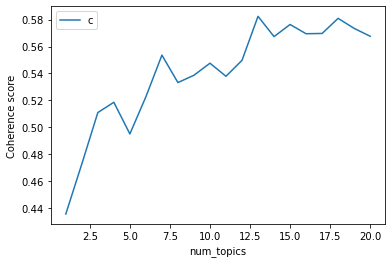

Wall time: 2min 58s


In [34]:
%%time
lmlist_lsi, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['comment_cleaned'].to_list(), limit=21, model= "lsi")

According to the coherence the best number of topics are between 3-7, however you must select the topics using both the coherence and visual inspection.


In [35]:
display_topics(lmlist_lsi[2])

Topic 0:
bien solo videos cosas explica hace creo hacer contenido basico 

Topic 1:
bien solo videos video hacer explicado hace mejor instructor contenido 

Topic 2:
solo videos explica falta basico contenido habla mejor creo video 



Now, Let's try another model

## Latent Dirichlet Allocation Model

In [36]:
ldamodel = LdaModel(corpus=corpus, num_topics=20, id2word=dictionary)

In [37]:
display_topics(ldamodel)

Topic 0:
introduccion mejor basicas entend excelente espero alguien basico solo rapido 

Topic 1:
podria mejor mejorar pract creo ingles audio explicacion momentos course 

Topic 2:
habla videos parte conoc ejemplo unico mejor final gratis java 

Topic 3:
video audio instructor mala rap aburrido seguir dificil presentacion aporta 

Topic 4:
bien gratuito profesor cosas veces varias rapido deja video iniciar 

Topic 5:
curs bas demasiado ahora explicaciones cosas contenido bien faltan tutorial 

Topic 6:
falta tem ejempl instructor recien hace practicar explicacion good aprende 

Topic 7:
aprendi html  + 0.021*  + 0.020*  + 0.020*  + 0.020*  + 0.018*  + 0.018*  + 0.018* 

Topic 8:
programacion personas conocimiento instructor moment basico ense solo lenguaje tema 

Topic 9:
interesante interes tema ense parece graci cosas basico aprender esper 

Topic 10:
temas datos bien base errores agradece explicar estan falta error 

Topic 11:
informacion conten tiempo util falta pierde saber poder

Find out the optimal number of topics for the LDA model based on the coherence metric:

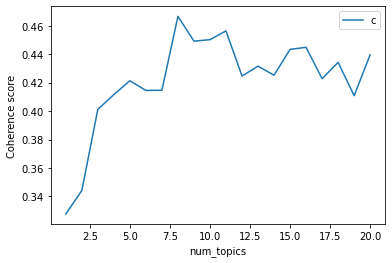

In [38]:
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['comment_cleaned'].to_list(), limit=21, model= "lda")

For this model it seems that  9 or 18, again we must to check the keywords too.

### Comparing the Model Coherence of the Best Models

we made 3 models, now let's compare each other's  coherence

In [39]:
ldamodel = lmlist[11]
lsimodel = lmlist_lsi[2]

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [40]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

<AxesSubplot:>

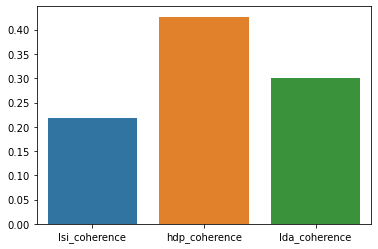

In [41]:
import seaborn as sns

coherences = [lsi_coherence, hdp_coherence, lda_coherence]
n = len(coherences)
x = ['lsi_coherence','hdp_coherence', 'lda_coherence']
sns.barplot(x, coherences)


We can see that the **LdaModel** model **with 8 topics** has the higher value of
coherence

Examine the keyword to get the topics of the best model

In [42]:

display_topics(ldamodel)

Topic 0:
basico bien solo bastante tema instructor conceptos creo mejor demasiado 

Topic 1:
bi informacion basico demasiado general contenido bien explica momento ahora 

Topic 2:
basico aprend vide cosas menos esper esperaba basic bien ense 

Topic 3:
bien curs explic interesante explicacion excelente contenido falta clar sonido 

Topic 4:
eleccion falta videos solo tema mejor hace conten ejemplos podria 

Topic 5:
solo claro cada explica bien basico graci instructor introduccion ahor 

Topic 6:
explicacion gratis informacion gratuito conceptos pract buena util video clara 

Topic 7:
bien bas explica explicado demasiado facil introduccion rapido parece ense 

Topic 8:
interes cosas mejor video tutorial aprendi aprender contenido espero poder 

Topic 9:
bien audio explicar mejor paso podria explica mejorar siento ejemplo 

Topic 10:
 + 0.012*  + 0.012*  + 0.011*  + 0.011*  + 0.010*  + 0.010*  + 0.010*  + 0.010*  + 0.010* 

Topic 11:
solo cl bien ense servidor falta ejemplos pagina tem

It looks like the topics are:
* Topic 0: felicitaciones
* Topic 1: expectativas
* Topic 2: experiencia
* Topic 3: contenido
* Topic 4: instructor
* Topic 5: material
* Topic 6: video
* Topic 7: lenguaje
* Topic 8: ejercicios
* Topic 9: titulo
* Topic 10: temas
* Topic 11: explicación


In [43]:
label_dicc = {0:'felicitaciones', 1:'expectativas', 2:'experiencia', 3: 'contenido', 4:'instructor', 5:'material', 6:'video', 
              7:'lenguaje', 8:'ejercicios', 9: 'titulo', 10:'temas', 11:'explicación'}

Let´s check the keyword when we selecting another number of topics (14)

In [44]:
ldamodel_16 =lmlist[16]


In [45]:
display_topics(ldamodel_16)

Topic 0:
interesante paso bien mundo solo empezar super creo ingles dice 

Topic 1:
momento rapido gusto cosas gustaria explicaciones entend util sido moment 

Topic 2:
informacion programacion basicos excelente temas base ejemplos solo basica datos 

Topic 3:
videos instructor solo nota tiempo explicar video parte instalacion explica 

Topic 4:
explicacion lento gratuito hace video cosas principiantes contenido falta mala 

Topic 5:
demasiado basico bas conten bien conceptos linux bastante conocer contenido 

Topic 6:
falto temas podria creo mejorar corto mayor sencillo bastante informacion 

Topic 7:
deberia hacer clara basico clar servidor aprendizaje falta explica parece 

Topic 8:
solo gratis basico pract cosas cursos youtube mismo cl pense 

Topic 9:
preguntas curs detall iniciar bien aunque creo necesita dudas cuestionarios 

Topic 10:
bi explica bueno comandos bien hace complet video version explico 

Topic 11:
curs interes esperaba aprend poca musica course fondo good practica

# Classifiying all documents

now that we have been select the best model and topics number, is time to assign a topic to each document, means **cluster** according to the topics

In [46]:
from tqdm.notebook import tqdm_notebook

def format_topics_sentences(ldamodel=0, corpus=corpus, texts=0):
    # Init output
    sent_topics_df = pd.DataFrame()-n

    # Get main topic in each document
    for i, row in tqdm_notebook(enumerate(ldamodel[corpus]), total=len(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus=corpus, texts=df_news['comment_cleaned'].to_list())



  0%|          | 0/21448 [00:00<?, ?it/s]

In [47]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6445,"bien, curs, explic, interesante, explicacion, excelente, contenido, falta, clar, sonido","[introduccion, bien, deberian, hacerlo, dirigido, fotos, rp]"
1,1,6.0,0.5417,"explicacion, gratis, informacion, gratuito, conceptos, pract, buena, util, video, clara","[explican, mayori]"
2,2,5.0,0.5837,"solo, claro, cada, explica, bien, basico, graci, instructor, introduccion, ahor","[pronto, evaluarlo, comparandolo, calidad, cursos, bajo, pueden, descargar, archivos, estan, sonido, malo, escucha, turbi]"
3,3,0.0,0.5820,"basico, bien, solo, bastante, tema, instructor, conceptos, creo, mejor, demasiado","[excelente, detallado, menos, leido, calidad, seria, superior, tema, explicar, leer, men]"
4,4,1.0,0.6434,"bi, informacion, basico, demasiado, general, contenido, bien, explica, momento, ahora","[parece, podria, algun, peque, repaso, terminos, comunes, ademas, ejempl]"
5,5,1.0,0.4519,"bi, informacion, basico, demasiado, general, contenido, bien, explica, momento, ahora","[parte, curso, profesor, mismo, curso, gratis, especializado, hacking, igualmente, bien, explic]"
6,6,2.0,0.8690,"basico, aprend, vide, cosas, menos, esper, esperaba, basic, bien, ense","[gusto, hacking, python, aprende, python, hacking]"
7,7,0.0,0.8468,"basico, bien, solo, bastante, tema, instructor, conceptos, creo, mejor, demasiado","[habla, hacking, apartados, solo, decepcion]"
8,8,7.0,0.8973,"bien, bas, explica, explicado, demasiado, facil, introduccion, rapido, parece, ense","[introduccion, breve, rapida, lenguaje, programacion, python, curso, auditoria, informatica, final, curso, breve, ejemplo, hacer, cumplido, exactamente, expectativas, reconocer, tutor, esforzado, involucrado, ejemplos, lenguaj]"
9,9,7.0,0.9083,"bien, bas, explica, explicado, demasiado, facil, introduccion, rapido, parece, ense","[parecio, super, bien, curso, personas, quieran, iniciarse, lenguaje, programacion, python]"


We selected the ldamodel with 12 topics and asigned a dominant topic to each document, now let map each topic with a label 

first let's create the dictionary

In [48]:
label_dicc = {0:'felicitaciones', 1:'expectativas', 2:'experiencia', 3: 'contenido', 4:'instructor', 5:'material', 6:'video', 
              7:'lenguaje', 8:'ejercicios', 9: 'titulo', 10:'temas', 11:'explicación'}

In [49]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype('int64')


In [50]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].map(label_dicc)
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,contenido,0.6445,"bien, curs, explic, interesante, explicacion, excelente, contenido, falta, clar, sonido","[introduccion, bien, deberian, hacerlo, dirigido, fotos, rp]"
1,1,video,0.5417,"explicacion, gratis, informacion, gratuito, conceptos, pract, buena, util, video, clara","[explican, mayori]"
2,2,material,0.5837,"solo, claro, cada, explica, bien, basico, graci, instructor, introduccion, ahor","[pronto, evaluarlo, comparandolo, calidad, cursos, bajo, pueden, descargar, archivos, estan, sonido, malo, escucha, turbi]"
3,3,felicitaciones,0.5820,"basico, bien, solo, bastante, tema, instructor, conceptos, creo, mejor, demasiado","[excelente, detallado, menos, leido, calidad, seria, superior, tema, explicar, leer, men]"
4,4,expectativas,0.6434,"bi, informacion, basico, demasiado, general, contenido, bien, explica, momento, ahora","[parece, podria, algun, peque, repaso, terminos, comunes, ademas, ejempl]"
5,5,expectativas,0.4519,"bi, informacion, basico, demasiado, general, contenido, bien, explica, momento, ahora","[parte, curso, profesor, mismo, curso, gratis, especializado, hacking, igualmente, bien, explic]"
6,6,experiencia,0.8690,"basico, aprend, vide, cosas, menos, esper, esperaba, basic, bien, ense","[gusto, hacking, python, aprende, python, hacking]"
7,7,felicitaciones,0.8468,"basico, bien, solo, bastante, tema, instructor, conceptos, creo, mejor, demasiado","[habla, hacking, apartados, solo, decepcion]"
8,8,lenguaje,0.8973,"bien, bas, explica, explicado, demasiado, facil, introduccion, rapido, parece, ense","[introduccion, breve, rapida, lenguaje, programacion, python, curso, auditoria, informatica, final, curso, breve, ejemplo, hacer, cumplido, exactamente, expectativas, reconocer, tutor, esforzado, involucrado, ejemplos, lenguaj]"
9,9,lenguaje,0.9083,"bien, bas, explica, explicado, demasiado, facil, introduccion, rapido, parece, ense","[parecio, super, bien, curso, personas, quieran, iniciarse, lenguaje, programacion, python]"


In [51]:
df_news['labels'] = df_dominant_topic['Dominant_Topic']
df_news['label_confidence'] = df_dominant_topic['Topic_Perc_Contrib']

Let's examine some text and its topics

In [52]:
df_news[['comment', 'labels']].head(10)

,comment,labels
6545,como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,contenido
6734,Explican poco... se lee la mayoría,contenido
6738,"es muy pronto para evaluarlo, comparandolo con la calidad de otros cursos este es bajo, no se pueden descargar los archivos ya que no estan en PDF y el sonido es malo, se escucha turbio.",felicitaciones
6739,"Excelente, muy detallado. Si fuera menos « leído » la calidad sería superior! El tema da para explicar más y leer menos",contenido
6782,"Me parece que podria dar algun pequeño repaso de terminos comunes, ademas de dar mas ejemplos",experiencia
7061,Una parte del curso fue algo que el profesor mismo tiene en otro curso gratis.\nPero lo especializado a Hacking está igualmente bien explicado.,explicación
7084,"No me gusto. Más que Hacking con Python... era aprende Python, de hacking poco y nada.",experiencia
7088,habla de hacking y son dos apartados que solo son web. DECEPCIONANTE.,experiencia
7113,"Es una introducción breve y rápida al lenguaje de programación Python. No es un curso de Auditoria informática, ya que al final del curso se da un breve ejemplo de como hacer Scraping.No ha cumplido exactamente con mis expectativas pero he de reconocer que el tutor se ha esforzado e involucrado en los ejemplos del lenguaje.",contenido
7115,Me pareció super bien el curso para las personas que quieran iniciarse en el lenguaje de programación python,instructor


In [53]:
df_news[ df_news['labels'] == 'instructor'].sort_values(by='label_confidence',ascending=False).head(10)

,id,course,rating,comment,user,tag,comment_cleaned,labels,label_confidence
12651,39746034,1212882,3.5,"Buen curso, le doy 3,5 estrellas porque debería tener ejercicios propuestos para uno practicar. Me parece que estructuralmente debería empezar explicando algunos conceptos antes de usarlos, por ejemplo las celdas.",Jesus David Santos,neg,"[curso, estrellas, deberia, tener, ejercicios, propuestos, practicar, parece, estructuralmente, deberia, empezar, explicando, conceptos, usarlos, ejemplo, celd]",instructor,0.9389
2998,52602864,1890392,2.5,Mis expectativas era poder ver un caso donde a traves de la herramienta se fuera desarrollando una investigación a un objetivo e ir documentando el mismo. La sensacion fue que se mostraron tips basicos y no se exploró mas a fondo las herramientas como osint.,Ronald Tellez V,neg,"[expectativas, poder, caso, traves, herramienta, desarrollando, investigacion, objetivo, documentando, mismo, sensacion, mostraron, tips, basicos, exploro, fondo, herramientas, osint]",instructor,0.9295
5655,64325410,448168,3.0,muy bien pero utiliza terminos que aun desconosco ejemplo back ???',Mary Mar Puerta Carrillo,neg,"[bien, utiliza, terminos, desconosco, ejemplo, back]",instructor,0.9166
4285,12610948,1068258,3.5,Promociona mucho su sitio y cursos fuera de udemy que me hace dudar si adquiri un curso incompleto,Rodolfo Ponce de Leon,neg,"[promociona, sitio, cursos, udemy, hace, dudar, adquiri, curso, incomplet]",instructor,0.9084
4476,4440868,565188,0.5,"Mala explicación, no preparo lo que tenia que mostrar antes, parece un tutorial traducido por alguien que sabe poco del tema",DanielCanedo,neg,"[mala, explicacion, preparo, tenia, mostrar, parece, tutorial, traducido, alguien, sabe, tem]",instructor,0.9083
11544,23014696,1192848,1.0,solo es puro concepto,Alejandro Martinez Olivares,neg,"[solo, puro, concept]",instructor,0.8854
1670,60175150,2577308,3.0,"corto, considere que se incluía técnicas de grabación",Fidel Isla,neg,"[corto, considere, incluia, tecnicas, grabacion]",instructor,0.8854
11544,9614538,779476,3.0,"Muy corto, ra muy basico",Emmanuel Carreño,neg,"[corto, bas]",instructor,0.8854
5064,27655626,1814494,2.5,"El contenido no está mal pero lo veo todo un poco desordenado a la hora de explicarlo y se hace bastante monótona su voz. También me habría gustado ir creando un proyecto según va explicando las distintas partes, pero cada video es una cosa inconexa de las anteriores con lo cual no terminas el curso con algo tangible sino con mil videos con una escalera por aquí, una cubierta por allá...\nEn definitiva el contenido lo veo bien pero no me gusta el curso en sí.",María Valera Garrote,neg,"[contenido, desordenado, hora, explicarlo, hace, bastante, monotona, tambien, habria, gustado, creando, proyecto, segun, explicando, distintas, partes, cada, video, cosa, inconexa, anteriores, terminas, curso, tangible, sino, videos, escalera, aqui, cubierta, alla, definitiva, contenido, bien, gusta, curs]",instructor,0.8854
3727,68909184,1652964,2.5,"Faltan recursos.\nEl hecho de que se invoquen todos los nodos mediante ""In-Canvas Search"" hace difícil de seguir el curso y muy difícil que tú por tu cuenta puedas progresar.\nNo hay feedback con el profesor.\nComo introducción sirve.",Jaume Molins,neg,"[faltan, recursos, hecho, invoquen, nodos, mediante, canvas, search, hace, dificil, seguir, curso, dificil, cuenta, puedas, progresar, feedback, profesor, introduccion, sirv]",instructor,0.8693


In [54]:
df_news.sort_values(by='label_confidence',ascending=False).head(10)

,id,course,rating,comment,user,tag,comment_cleaned,labels,label_confidence
1680,57006440,2577308,3.5,"Si definitivamente ha sido una buena opción aunque hay algunas fallas técnicas como:\nEn varias ocasiones no coincide el texto con la voz y como que da la impresión de que no se revisó el trabajo final. Otro error es que encima el texto enmarcado en negro con el texto del documento y si pierde el texto del documento.\nPero, en cuanto al conocimiento y la experiencia del titular del curso todo está bien.\nGracias.",Javier Ocampo Blas,neg,"[definitivamente, sido, opcion, aunque, fallas, tecnicas, varias, ocasiones, coincide, texto, impresion, reviso, trabajo, final, error, encima, texto, enmarcado, negro, texto, documento, pierde, texto, documento, cuanto, conocimiento, experiencia, titular, curso, bien, graci]",contenido,0.9647
640,69382260,2518830,2.5,"No se puede hacer un curso improvisando. Se necesita un guión que se crea teniendo claro lo que se quiere enseñar y practicando antes los ejemplos de lo que se quiere enseñar. Aunque hay lugar para los comentarios espontáneos o las improvisaciones fuera de guión, el ensayo-error produce una imagen pésima en alguien que pretende enseñar. Editar los vídeos eliminando lo superfluo o los errores, o doblando de nuevo la explicación, tampoco está de más.",Julio Gonzalez,neg,"[puede, hacer, curso, improvisando, necesita, guion, crea, claro, quiere, ense, practicando, ejemplos, quiere, ense, aunque, lugar, comentarios, espontaneos, improvisaciones, guion, ensayo, error, produce, imagen, pesima, alguien, pretende, ense, editar, videos, eliminando, superfluo, errores, doblando, nuevo, explicacion, tampoc]",ejercicios,0.9618
12651,39746034,1212882,3.5,"Buen curso, le doy 3,5 estrellas porque debería tener ejercicios propuestos para uno practicar. Me parece que estructuralmente debería empezar explicando algunos conceptos antes de usarlos, por ejemplo las celdas.",Jesus David Santos,neg,"[curso, estrellas, deberia, tener, ejercicios, propuestos, practicar, parece, estructuralmente, deberia, empezar, explicando, conceptos, usarlos, ejemplo, celd]",instructor,0.9389
2998,52602864,1890392,2.5,Mis expectativas era poder ver un caso donde a traves de la herramienta se fuera desarrollando una investigación a un objetivo e ir documentando el mismo. La sensacion fue que se mostraron tips basicos y no se exploró mas a fondo las herramientas como osint.,Ronald Tellez V,neg,"[expectativas, poder, caso, traves, herramienta, desarrollando, investigacion, objetivo, documentando, mismo, sensacion, mostraron, tips, basicos, exploro, fondo, herramientas, osint]",instructor,0.9295
8334,65716920,2819881,2.5,"Fue aburrido. La lección de instalación es innecesaria. Pues hay muchos programas que hacen lo mismo. Y no se los menciona.\nTampoco habla de como se ""instala"" git en otros Sistemas Operativos.",Ana Karen Yurquina,neg,"[aburrido, leccion, instalacion, innecesaria, pues, programas, hacen, mismo, menciona, tampoco, habla, instala, sistemas, oper]",lenguaje,0.9295
5655,64325410,448168,3.0,muy bien pero utiliza terminos que aun desconosco ejemplo back ???',Mary Mar Puerta Carrillo,neg,"[bien, utiliza, terminos, desconosco, ejemplo, back]",instructor,0.9166
230,91970850,2297910,3.0,"Falta librerías (por ejemplo socket que se usa mucho para scripts); explicar qué significa cada objeto en inglés para que no se aprenda de memoria y se entienda qué significa (no sólo para qué sirve), por ejemplo len(gth).\nComo primera parte o introducción al lenguaje está bien, lejos de experto.",Christian Martins Farías,neg,"[falta, librerias, ejemplo, socket, scripts, explicar, significa, cada, objeto, ingles, aprenda, memoria, entienda, significa, solo, sirve, ejemplo, primera, parte, introduccion, lenguaje, bien, lejos, expert]",temas,0.9165
18555,73218940,2930134,1.0,La explicación me parece deficiente. De igual forma los temas me parecen desactualizados. No incluye formatos.,Alan Miguel,neg,"[explicacion, parece, deficien

### let's see the distribution of topics


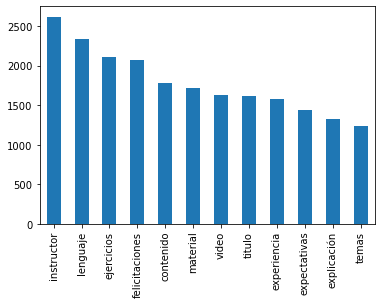

In [55]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

The topis are almost balanced, so we are good

finally that we have our models set up, as well as analyzed, we can go
ahead to visualizing them.

In [56]:
!pip install pyLDAvis

In [57]:
import pyLDAvis

pyLDAvis.enable_notebook()

In [58]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.021297 -0.034630       1        1  10.642357
8      0.083971  0.009111       2        1  10.522100
7     -0.030777 -0.004642       3        1   9.918330
0      0.005388 -0.039922       4        1   9.352767
5     -0.007861 -0.069582       5        1   8.945814
10     0.183944  0.176736       6        1   7.594612
2      0.033005 -0.011587       7        1   7.566442
9      0.032962 -0.104123       8        1   7.564454
11     0.121097 -0.072570       9        1   7.489982
3     -0.106675 -0.083526      10        1   7.168204
6     -0.113304  0.172222      11        1   7.013817
1     -0.180454  0.062514      12        1   6.221121, topic_info=               Term         Freq        Total Category  logprob  loglift
306        eleccion   795.000000   795.000000  Default  30.0000  30.0000
470              bi   576.000000   576.000000  Default  29.0000  29.0000
342            curs  1033.000000  1033.000000  Default  28.0000  28.0000
37           explic   445.000000   445.000000  Default  27.0000  27.0000
471             bas   546.000000   546.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
188          aunque    76.535608   798.252512  Topic12  -5.0150   0.4326
5      introduccion    59.194915   680.715421  Topic12  -5.2719   0.3349
32           parece    58.437664   881.232881  Topic12  -5.2848   0.0639
1401  introductorio    53.554531   170.501572  Topic12  -5.3720   1.6192
50             solo    55.263076  1715.980211  Topic12  -5.3406  -0.6584

[879 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1834      8  0.961972  abarcar
1734      4  0.945750  abordar
3344     11  0.988156    about
2275     12  0.970219     abre
578       3  0.950446    aburr
...     ...       ...      ...
155       5  0.016197  youtube
155       7  0.021596  youtube
155       9  0.016197  youtube
155      11  0.426517  youtube
155      12  0.005399  youtube

[2684 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 8, 1, 6, 11, 3, 10, 12, 4, 7, 2])